<div class="alert alert-danger" role="alert">
    <h3>This notebook is work in progress. Feel free to <span style="color:red">comment</span> if you have any suggestions   |   motivate me with an <span style="color:red">upvote</span> if you like this project.</h3>
</div>

# High Protein Food
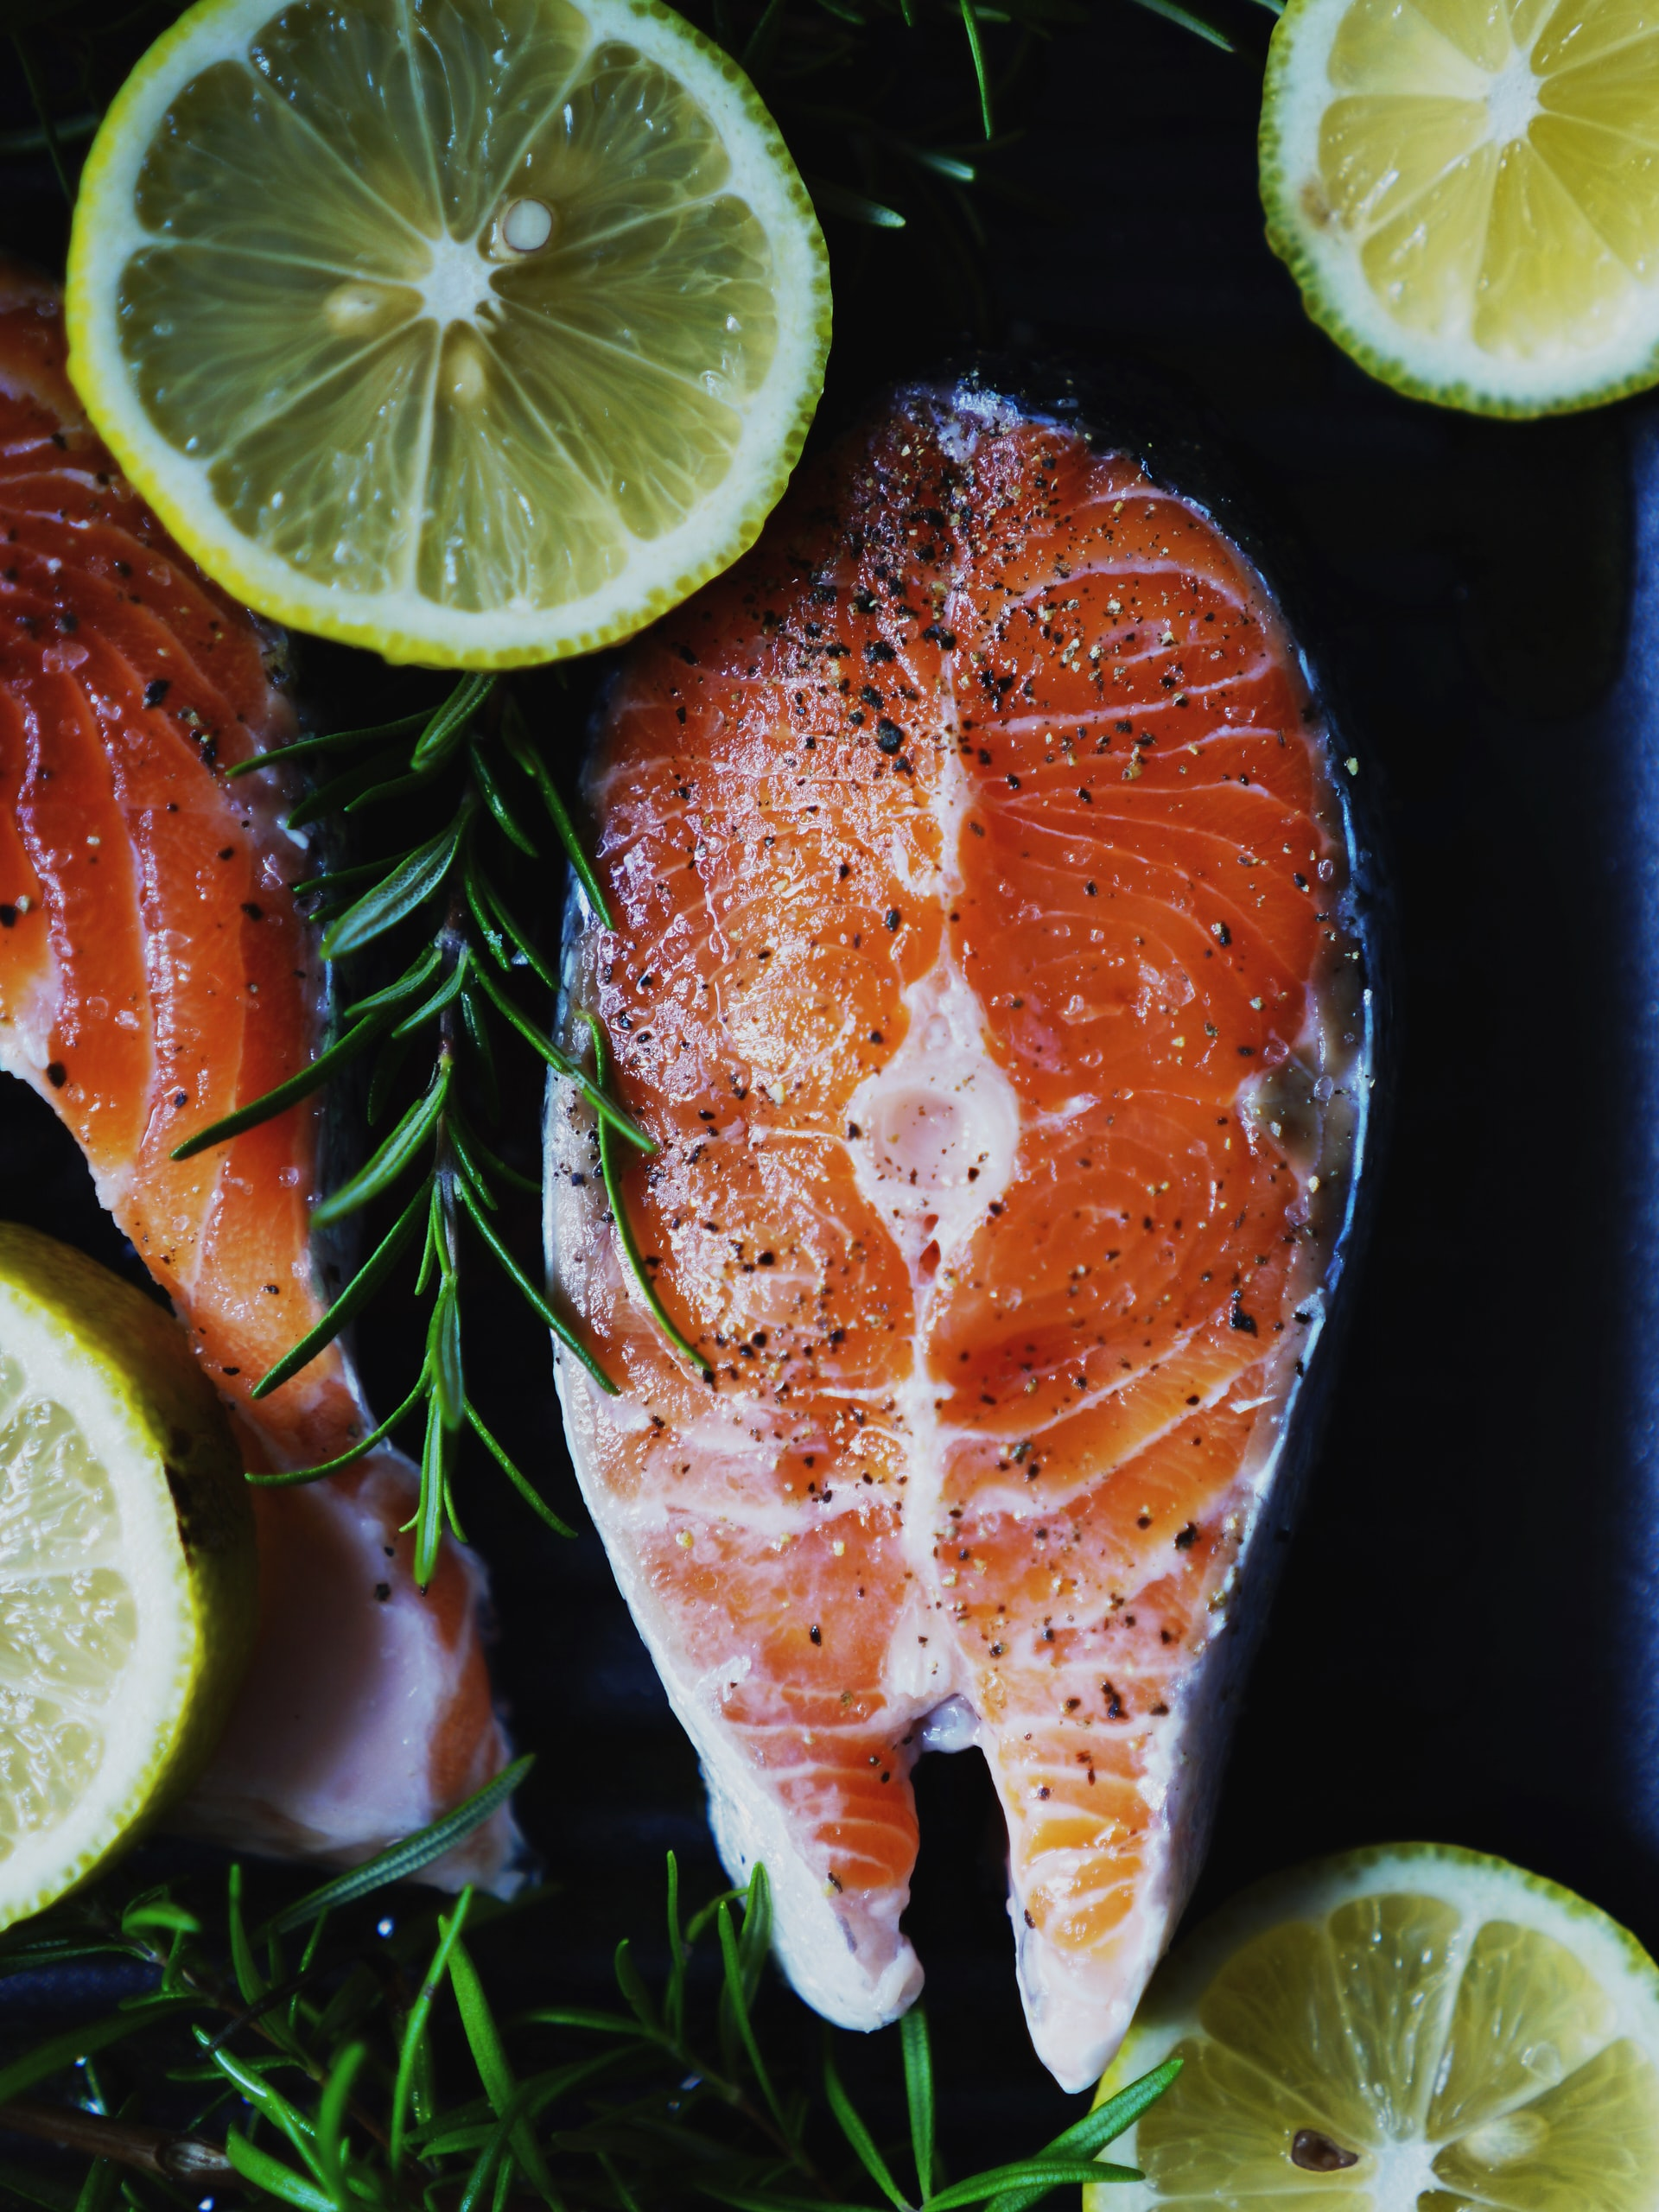

source: https://unsplash.com/photos/MZ0U0g6RQpQ

In this notebook, I will take a look at a dataset containing various nutrition facts. Let's see what we can find. 

In [ ]:
import pandas as pd
pd.options.display.float_format = '{:20,.2f}'.format # suppress scientific notation
pd.set_option('display.max_columns', None) # display all columns of a df
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv('/kaggle/input/nutritional-values-for-common-foods-and-products/nutrition.csv').drop(['Unnamed: 0', 'serving_size'], axis=1)
# use the name as the index 
names = data['name']
data = data.drop('name', axis=1)

Let's first of all get ridd of all the units to obtain cleaned numerical data. Each column has one unique unit.

In [ ]:
numbers = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '.']

def delete_unit(x):
    if isinstance(x, str):
        for char in range(len(x)):
            if x[char] not in numbers:
                return float(x[0:char:1])
    else: 
        return x
            
cols_with_unit = data.columns.drop(['calories'])
for col in data[cols_with_unit]:
    data[col] = data[col].apply(delete_unit)
data.head()

* The data seems to contain many `Null values`

# get an Overview
Finally! We can get started and get an overview of the dataset

In [ ]:
data.describe()

* `lucopene` seems to contain zeros only -> drop it

* Most variables seem to be extremely skewed, cause e.g. many of them have at least 50% zero values.

In [ ]:
data = data.drop('lucopene', axis=1)

# Missing Values

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,4))
ax1.set_title('Missing Values per column')
ax1.set_ylabel('Number of Null Values in %')
num_rows = data.shape[0]
nulls_per_col = data.isna().sum()
nulls_per_col_sorted = nulls_per_col.sort_values(ascending=False)
# we only want to display columns having at least one nullvalue
mask_greater_zero = nulls_per_col>0
(nulls_per_col_sorted*100/num_rows)[mask_greater_zero].plot.bar(ax=ax1);

The amount of missing values in this dataset is extremely high. 

Let's remove columns and rows containing too many missing values

In [ ]:
# drop columns having at least ~1/3 null values
thresh_cols = int(data.shape[0] / 3)
data = data.dropna(axis=1, thresh=thresh_cols)

# drop rows having at least ~50% null values 
thresh_rows = int(data.shape[1] / 2)
data = data.dropna(axis=0, thresh=thresh_rows)

Replace the rest of the missing values with the column means

In [ ]:
from sklearn.impute import SimpleImputer

cols = data.columns
imputer = SimpleImputer(strategy='mean')
data = pd.DataFrame(imputer.fit_transform(data), columns=cols)
data

# Outliers
get rid of extreme outliers. Detect them using zscores

In [ ]:
from scipy import stats
data_zscore = data.apply(stats.zscore, axis=0)
mask_outliers = np.logical_not(((data_zscore>4).any(axis=1)).values + ((data_zscore<-4).any(axis=1)).values)
data.loc[mask_outliers,:]

# Products with high Protein and low Calories

I am interested in food having at least 30g of proteins and as few calories as possible. Let's take a look at these products.

In [ ]:
# rows with more than 30g proteins
data_high_protein = data.loc[data['protein']>30, ['protein', 'calories']]

# sort with 
# priority 1: low calories
# priority 2: high protein
data_high_protein = data_high_protein.sort_values(by=['calories', 'protein'], ascending=[True, False]).head(10)
data_high_protein

Now let's find the food which provides the most proteins per calory!

In [ ]:
def divide(x,y):
    if y!=0:
        return x / y
    else:
        return 0
    
data_proPerCal = data.loc[data['calories']!=0, ['calories','protein']]
data_proPerCal['proteinPerCalory'] = data_proPerCal.apply(lambda row: divide(row['protein'], row['calories']), axis=1)

data_proPerCal = data_proPerCal['proteinPerCalory'].sort_values(ascending=False).head(10)

In [ ]:
fig, ax1 = plt.subplots()
data_proPerCal.plot.barh(title='Products with highest amount of protein amount per calory', ax=ax1)
ax1.set_yticklabels(names[data_proPerCal.index].values)
ax1.set_xlabel('Grams of Protein per calory')
plt.show()

Let's take a look at fat as well!

In [ ]:
# font sizes, this has to be updated for every plot, if changed once
plt.rc('axes', titlesize=40)    
plt.rc('axes', labelsize=30)    
plt.rc('xtick', labelsize=20)    
plt.rc('ytick', labelsize=20)

with plt.style.context('dark_background'):
    fig, ax1  = plt.subplots(figsize=(20,10))
    df_plot = pd.DataFrame(data, columns=['fat', 'calories'])
    df_plot.plot(kind='scatter', x='fat', y='calories', alpha=0.4, c='yellow', ax=ax1, edgecolor='black')

    ax1.set_xlabel(f'fat in g per 100g')
    ax1.set_ylabel(f'calories per 100g')
    ax1.set_title('Interaction between fat and calories')    

    fig.tight_layout()
    plt.savefig('fat')
    plt.show()

We can clearly see a linear relationship between fat and calories.